In [1]:
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def load_maskrcnn_model(save_path, device):
    """
    Load a trained PyTorch Mask R-CNN model

    Args:
        save_path: Path to the saved model
        device: Device to load the model to (cuda/cpu)
    Returns:
        model: The loaded model
    """
    # Initialize the model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=33)

    # Load the state dict with proper file handling
    with open(save_path, 'rb') as f:
        state_dict = torch.load(f, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)

    # Move model to device
    model = model.to(device)

    # Set to evaluation mode
    model.eval()

    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

maskrcnn_path="drive/MyDrive/training_data/quadrant_enumeration/dental_maskrcnn.pth"
markrcnn_model = load_maskrcnn_model(maskrcnn_path, device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


# Modified UNet

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F





class BBConvLayer(nn.Module):
    """Bounding Box Processing Layer with Channel Reduction."""
    def __init__(self, in_channels, out_channels, reduce_channels=128):
        super(BBConvLayer, self).__init__()
        self.bb_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(out_channels, reduce_channels, kernel_size=1)  # Reduce channels
        )

    def forward(self, x):
        return self.bb_conv(x)



class ModifiedUNet(nn.Module):
    def __init__(self, image_channels=1, bbox_channels=1, out_channels=33):  # in_channels=2 for image + bbox info
        super(ModifiedUNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        def up_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # Note: in_channels is now 2 (grayscale image + bbox mask)
        self.encoder1 = conv_block(image_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.bb_processing = BBConvLayer(bbox_channels, 512)

        self.upconv4 = up_block(1024, 512)
        self.decoder4 = conv_block(512 + 512 + 128, 512)  # Adjust input channels
        self.upconv3 = up_block(512, 256)
        self.decoder3 = conv_block(256 + 256 + 128, 256)
        self.upconv2 = up_block(256, 128)
        self.decoder2 = conv_block(128 + 128 + 128, 128)
        self.upconv1 = up_block(128, 64)
        self.decoder1 = conv_block(64 + 64 + 128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, image, bbox):
        # Encoder
        enc1 = self.encoder1(image)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        # Process bounding box features
        bbox_features = self.bb_processing(bbox)

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder with resizing bbox_features
        dec4 = self.upconv4(bottleneck)
        bbox_resized4 = F.interpolate(bbox_features, size=enc4.size()[2:], mode='bilinear', align_corners=False)
        dec4 = self.decoder4(torch.cat((dec4, enc4, bbox_resized4), dim=1))

        dec3 = self.upconv3(dec4)
        bbox_resized3 = F.interpolate(bbox_features, size=enc3.size()[2:], mode='bilinear', align_corners=False)
        dec3 = self.decoder3(torch.cat((dec3, enc3, bbox_resized3), dim=1))

        dec2 = self.upconv2(dec3)
        bbox_resized2 = F.interpolate(bbox_features, size=enc2.size()[2:], mode='bilinear', align_corners=False)
        dec2 = self.decoder2(torch.cat((dec2, enc2, bbox_resized2), dim=1))

        dec1 = self.upconv1(dec2)
        bbox_resized1 = F.interpolate(bbox_features, size=enc1.size()[2:], mode='bilinear', align_corners=False)
        dec1 = self.decoder1(torch.cat((dec1, enc1, bbox_resized1), dim=1))

        # Final output
        return self.final_conv(dec1)





In [ ]:

class DiceLoss(nn.Module):
    def __init__(self, weights=None):
        """
        DiceLoss with optional class weights.

        Args:
            weights (torch.Tensor): Weights for each class. Shape: (num_classes,)
        """
        super(DiceLoss, self).__init__()
        self.weights = weights

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)  # Class probabilities
        target = F.one_hot(target, num_classes=33).permute(0, 3, 1, 2).float()  # One-hot encode target

        intersection = (pred * target).sum(dim=(2, 3))  # Per class intersection
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))  # Per class union

        dice_score = 2.0 * intersection / (union + 1e-6)  # Per class Dice score

        # Apply weights
        if self.weights is not None:
            dice_score = dice_score * self.weights.view(1, -1)

        return 1.0 - dice_score.mean()  # Mean weighted Dice loss


def dice_metric(pred, target, num_classes=33):
    """
    Compute per-class Dice scores.
    """
    pred = torch.argmax(pred, dim=1)  # Shape: (batch_size, H, W)
    dice_scores = []

    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union == 0:  # Avoid NaN for empty classes
            dice_scores.append(torch.tensor(1.0))  # Perfect score for empty classes
        else:
            dice_scores.append((2.0 * intersection) / (union + 1e-6))

    return dice_scores







In [5]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.transforms.functional as TF

class ModifiedToothSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, coco_json, maskrcnn_model, device, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.maskrcnn_model = maskrcnn_model
        self.device = device

        with open(coco_json, "r") as f:
            coco_data = json.load(f)

        self.image_info = {img["id"]: img for img in coco_data["images"]}
        self.image_annotations = {img_id: [] for img_id in self.image_info.keys()}
        for annotation in coco_data["annotations"]:
            self.image_annotations[annotation["image_id"]].append(annotation)

        self.image_ids = list(self.image_info.keys())
        print(f"Dataset initialized with {len(self.image_ids)} images.")

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_name = self.image_info[image_id]["file_name"]
        image_path = os.path.join(self.image_dir, image_name)

        # Load image
        image = Image.open(image_path).convert("L")  # Grayscale
        original_size = image.size

        # Create segmentation mask
        mask = Image.new("L", original_size, 0)
        draw = ImageDraw.Draw(mask)
        for annotation in self.image_annotations[image_id]:
            points = np.array(annotation["segmentation"]).reshape(-1, 2)
            draw.polygon([tuple(p) for p in points], fill=annotation["category_id"]+1)

        # Get Mask R-CNN predictions on original size image
        with torch.no_grad():
            # Convert to tensor without resizing and without adding batch dimension
            image_tensor = TF.to_tensor(Image.open(image_path).convert("L")).to(self.device)  # Shape: [1, H, W]
            maskrcnn_pred = self.maskrcnn_model([image_tensor])[0]  # Pass as list of tensors

        # Create bbox mask at original size
        bbox_mask = torch.zeros((1, *original_size[::-1]), device=self.device)
        for box, label in zip(maskrcnn_pred['boxes'], maskrcnn_pred['labels']):
            x1, y1, x2, y2 = map(int, box.cpu().numpy())
            bbox_mask[:, y1:y2, x1:x2] = label.item()

        # Apply transforms to image and mask
        if self.transform:
            image, mask = self.transform(image, mask)

        # Resize bbox_mask to match transformed image size
        bbox_mask = F.interpolate(bbox_mask.unsqueeze(0), size=(256, 256),
                                mode='nearest').squeeze(0)

        return image, bbox_mask, mask
        # return TF.to_tensor(image), bbox_mask, TF.to_tensor(mask)

    def __len__(self):
        return len(self.image_ids)


from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

def train_modified_unet(model, train_loader, val_loader, epochs, device, weights):
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-3)

    if weights is not None:
        weights = weights.to(device)
        criterion = CrossEntropyLoss(weight=weights)
    else:
        criterion = CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, bbox_masks, masks in train_loader:
            images = images.to(device)
            bbox_masks = bbox_masks.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            # Concatenate image and bbox information
            # inputs = torch.cat([images, bbox_masks], dim=1)
            # outputs = model(inputs)
            outputs = model(images, bbox_masks)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Validation step
        model.eval()
        with torch.no_grad():
            all_dice_scores = {c: [] for c in range(33)}
            for images, bbox_masks, masks in val_loader:
                images = images.to(device)
                bbox_masks = bbox_masks.to(device)
                masks = masks.to(device)

                # inputs = torch.cat([images, bbox_masks], dim=1)
                # outputs = model(inputs)
                outputs = model(images, bbox_masks)
                per_class_dice = dice_metric(outputs, masks)
                for c, score in enumerate(per_class_dice):
                    all_dice_scores[c].append(score)

        mean_dice_scores = {c: sum(scores) / len(scores) for c, scores in all_dice_scores.items()}
        print(f"Epoch {epoch + 1}/{epochs}, Per-Class Dice Scores: {mean_dice_scores}")
        overall_dice = sum(mean_dice_scores.values()) / len(mean_dice_scores)
        print(f"Epoch {epoch + 1}/{epochs}, Overall Val Dice Score: {overall_dice:.4f}")



In [6]:
def transform(image, mask):
    image = TF.resize(image, (256, 256))
    mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)
    image = TF.to_tensor(image)
    mask = torch.from_numpy(np.array(mask, dtype=np.int64))  # Convert to tensor
    return image, mask

In [7]:

# Paths
base_dir = "drive/MyDrive/training_data/quadrant_enumeration"
image_dir = os.path.join(base_dir, "xrays_2048_1024")
mask_dir = os.path.join(base_dir, "masks_teeth_2048_1024")
coco_json = os.path.join(base_dir, "coco_quadrant_enumeration_2048_1024.json")


num_classes = 33
background_proportion = 0.9
tooth_proportion = 0.1 / 32  # Each of the 32 classes share 10%

# Compute weights
weights = [1 / tooth_proportion] * 32  # Equal weight for all 32 classes
weights.append(1 / background_proportion)  # Weight for background class

# Normalize weights
weights = torch.tensor(weights, dtype=torch.float32)
weights /= weights.sum()  # Normalize so weights sum to ~1

# Print weights for reference
print("Class Weights:", weights)



# Usage:
batch_size = 4

# Initialize Mask R-CNN
maskrcnn_model = load_maskrcnn_model(maskrcnn_path, device)
maskrcnn_model.eval()  # Set to evaluation mode

# 3. Create dataset
dataset = ModifiedToothSegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    coco_json=coco_json,
    maskrcnn_model=maskrcnn_model,
    device=device,
    transform=transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize modified U-Net (2 input channels for image + bbox mask)
model = ModifiedUNet(image_channels=1, bbox_channels=1, out_channels=33)



Class Weights: tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0001])
Dataset initialized with 634 images.


In [ ]:
# Train
train_modified_unet(model, train_loader, val_loader, epochs=60, device=device, weights=weights)

Epoch 1/60, Train Loss: 1.9185
Epoch 1/60, Per-Class Dice Scores: {0: tensor(0.9027, device='cuda:0'), 1: tensor(0., device='cuda:0'), 2: tensor(0., device='cuda:0'), 3: tensor(0., device='cuda:0'), 4: tensor(0., device='cuda:0'), 5: tensor(0., device='cuda:0'), 6: tensor(0., device='cuda:0'), 7: tensor(0., device='cuda:0'), 8: tensor(0.0312, device='cuda:0'), 9: tensor(0., device='cuda:0'), 10: tensor(0., device='cuda:0'), 11: tensor(0., device='cuda:0'), 12: tensor(0., device='cuda:0'), 13: tensor(0., device='cuda:0'), 14: tensor(0., device='cuda:0'), 15: tensor(0., device='cuda:0'), 16: tensor(0., device='cuda:0'), 17: tensor(0., device='cuda:0'), 18: tensor(0., device='cuda:0'), 19: tensor(0., device='cuda:0'), 20: tensor(0., device='cuda:0'), 21: tensor(0., device='cuda:0'), 22: tensor(0., device='cuda:0'), 23: tensor(0., device='cuda:0'), 24: tensor(0.0312, device='cuda:0'), 25: tensor(0., device='cuda:0'), 26: tensor(0., device='cuda:0'), 27: tensor(0., device='cuda:0'), 28: ten

NameError: name 'model' is not defined

In [10]:
import torch
import torch.nn.functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os

def save_model(model, save_path):
    """
    Save a trained PyTorch model

    Args:
        model: The trained model to save
        save_path: Path where the model will be saved
    """
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

def load_model(save_path, device):
    """
    Load a trained PyTorch model

    Args:
        save_path: Path to the saved model
        device: Device to load the model to (cuda/cpu)
    Returns:
        model: The loaded model
    """
    # Initialize the model architecture
    model = ModifiedUNet(image_channels=1, bbox_channels=1, out_channels=33)  # Match training architecture

    # Load the saved state dict
    model.load_state_dict(torch.load(save_path, map_location=device))

    # Move model to the specified device
    model = model.to(device)

    # Set to evaluation mode
    model.eval()

    return model

In [ ]:
# # Save model after training
# save_path = 'drive/MyDrive/training_data/quadrant_enumeration/bb_unet_maskrcnn.pth'
# save_model(model, save_path)

Model saved to drive/MyDrive/training_data/quadrant_enumeration/bb_unet_maskrcnn.pth


In [13]:
load_path = 'drive/MyDrive/training_data/quadrant_enumeration/bb_unet_maskrcnn.pth'
model = ModifiedUNet(image_channels=1, bbox_channels=1, out_channels=33)
model.load_state_dict(torch.load(load_path))
model.to(device)

<ipython-input-13-678c287e0071>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


ModifiedUNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=

In [40]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_visualize(mask_rcnn, unet, image_path, device, num_classes=32, mask_alpha=0.5):
    """
    Evaluate the two-stage model (Mask R-CNN + Modified UNet) on a single image and visualize predictions.

    Args:
        mask_rcnn (torch.nn.Module): Pretrained Mask R-CNN model
        unet (torch.nn.Module): Trained Modified UNet model
        image_path (str): Path to the input image
        device (torch.device): Device to run the models on
        num_classes (int): Number of segmentation classes (default: 32)
        mask_alpha (float): Transparency level for mask overlay (default: 0.5)
    """
    # Ensure models are in eval mode
    mask_rcnn.eval()
    unet.eval()

    # Load and preprocess the image
    original_image = Image.open(image_path).convert("L")  # Load as grayscale
    image_rgb = Image.open(image_path).convert("RGB")  # For visualization

    # Get original dimensions
    orig_width, orig_height = original_image.size

    # Create tensors for both models
    image_tensor_rcnn = TF.to_tensor(image_rgb).to(device)
    image_tensor_unet = TF.to_tensor(original_image).to(device)

    # Resize images for UNet (which expects 256x256)
    image_tensor_unet = F.interpolate(image_tensor_unet.unsqueeze(0),
                                    size=(256, 256),
                                    mode='bilinear',
                                    align_corners=False)

    # Step 1: Get Mask R-CNN predictions
    with torch.no_grad():
        rcnn_predictions = mask_rcnn([image_tensor_rcnn])[0]

        # Create bbox mask tensor (256x256 to match UNet input)
        bbox_mask = torch.zeros((1, 256, 256), device=device)

        # Calculate scaling factors
        scale_x = 256.0 / orig_width
        scale_y = 256.0 / orig_height

        # Filter predictions with confidence > 0.5
        confident_indices = rcnn_predictions['scores'] > 0.5
        boxes = rcnn_predictions['boxes'][confident_indices]
        labels = rcnn_predictions['labels'][confident_indices]

        # Fill bbox mask
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = map(lambda x: int(x.item()), box)
            # Scale coordinates to 256x256
            x1_scaled = int(x1 * scale_x)
            x2_scaled = int(x2 * scale_x)
            y1_scaled = int(y1 * scale_y)
            y2_scaled = int(y2 * scale_y)
            bbox_mask[:, y1_scaled:y2_scaled, x1_scaled:x2_scaled] = label.item()

    # Step 2: Get UNet predictions
    with torch.no_grad():
        unet_output = unet(image_tensor_unet, bbox_mask.unsqueeze(0))
        predicted_mask = torch.argmax(unet_output.squeeze(0), dim=0).cpu().numpy()

    # Step 3: Visualization
    # Resize original image for visualization
    image_resized = original_image.resize((256, 256))
    image_rgb_resized = image_rgb.resize((256, 256))

    # Create color map
    np.random.seed(42)
    color_map = np.zeros((num_classes, 3), dtype=np.uint8)
    for i in range(1, num_classes):
        color_map[i] = np.random.randint(0, 255, size=3)

    # Create visualization arrays
    image_array = np.array(image_rgb_resized)
    mask_overlay = np.zeros_like(image_array, dtype=np.uint8)

    # Fill mask overlay
    for c in range(1, num_classes):
        mask_overlay[predicted_mask == c] = color_map[c]

    # Blend images
    blended_image = (image_array * (1 - mask_alpha) + mask_overlay * mask_alpha).astype(np.uint8)

    # Draw bounding boxes
    image_with_boxes = image_rgb_resized.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Draw scaled boxes
    for box in boxes:
        x1, y1, x2, y2 = map(lambda x: int(x.item()), box)
        x1_scaled = int(x1 * scale_x)
        x2_scaled = int(x2 * scale_x)
        y1_scaled = int(y1 * scale_y)
        y2_scaled = int(y2 * scale_y)
        draw.rectangle([x1_scaled, y1_scaled, x2_scaled, y2_scaled], outline="red", width=2)

    # Create figure
    plt.figure(figsize=(15, 5))

    # Plot original image with boxes
    plt.subplot(1, 3, 1)
    plt.title("Original Image with Bounding Boxes")
    plt.imshow(image_with_boxes)
    plt.axis("off")

    # Plot segmentation mask
    plt.subplot(1, 3, 2)
    plt.title("Predicted Segmentation Mask")
    plt.imshow(predicted_mask, cmap="tab20b")
    plt.colorbar()
    plt.axis("off")

    # Plot blended result
    plt.subplot(1, 3, 3)
    plt.title("Blended Segmentation Result")
    plt.imshow(blended_image)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return predicted_mask, boxes  # Return predictions for potential further use

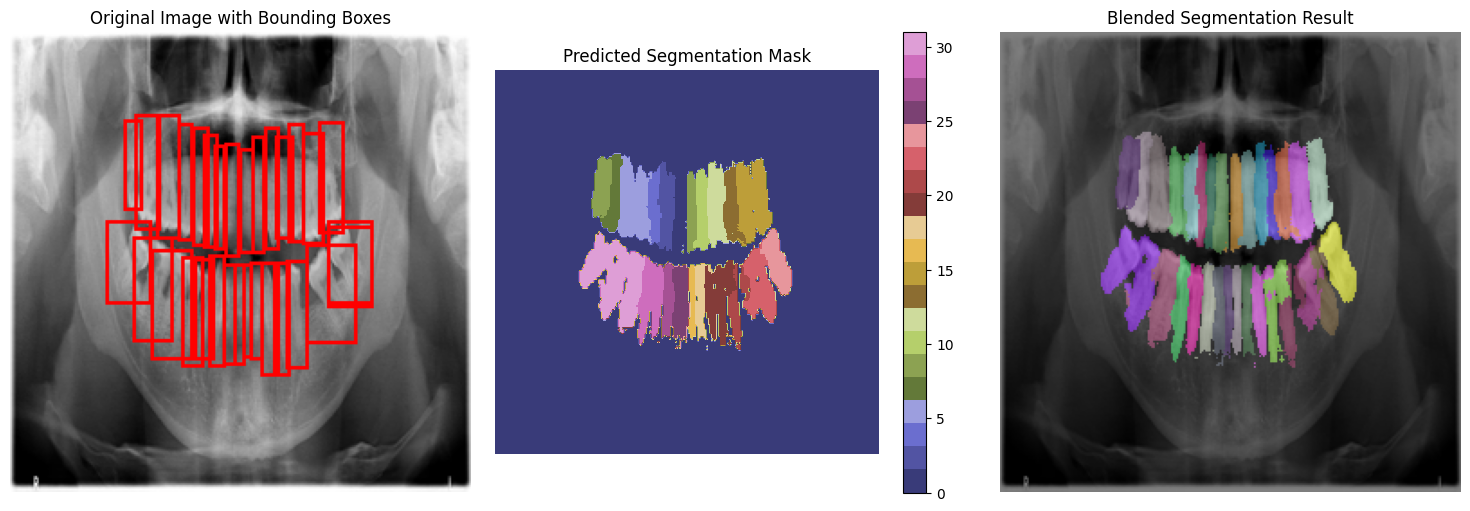

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 tensor([[1112.3047,  512.0883, 1195.2697,  767.7142],
         [1170.3374,  514.8227, 1242.5763,  767.7658],
         [ 908.3126,  253.7746,  959.4729,  486.5202],
         [ 856.2020,  228.0627,  922.0554,  480.8619],
         [ 822.1708,  506.5487,  908.1961,  731.9763],
         [1237.7338,  204.8803, 1306.0732,  469.6073],
         [1225.2080,  509.6386, 1320.7710,  750.5844],
         [1128.4615,  212.4877, 1199.6189,  487.6316],
         [1177.6274,  232.0648, 1259.9495,  461.5037],
         [1021.2867,  261.9036, 1082.6449,  495.5447],
         [ 884.4492,  499.9842,  955.8545,  747.5352],
         [1073.3254,  234.8255, 1135.0684,  493.5118],
         [1373.8340,  200.7315, 1484.6450,  449.9937],
         [ 764.0237,  500.0887,  858.1758,  745.6940],
         [ 426.60

In [41]:

# Example usage:



image_path = "drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_0.png"

evaluate_and_visualize(maskrcnn_model, model, image_path, device)



In [46]:
TOOTH_TYPE_MAPPING = {
    # Quadrant 1 (Upper Right)
    0: 'incisor',  # Central incisor
    1: 'incisor',  # Lateral incisor
    2: 'canine',   # Canine
    3: 'premolar', # First premolar
    4: 'premolar', # Second premolar
    5: 'molar',    # First molar
    6: 'molar',    # Second molar
    7: 'molar',    # Third molar

    # Quadrant 2 (Upper Left)
    8: 'incisor',  # Central incisor
    9: 'incisor',  # Lateral incisor
    10: 'canine',  # Canine
    11: 'premolar', # First premolar
    12: 'premolar', # Second premolar
    13: 'molar',    # First molar
    14: 'molar',    # Second molar
    15: 'molar',    # Third molar

    # Quadrant 3 (Lower Left)
    16: 'incisor',  # Central incisor
    17: 'incisor',  # Lateral incisor
    18: 'canine',   # Canine
    19: 'premolar', # First premolar
    20: 'premolar', # Second premolar
    21: 'molar',    # First molar
    22: 'molar',    # Second molar
    23: 'molar',    # Third molar

    # Quadrant 4 (Lower Right)
    24: 'incisor',  # Central incisor
    25: 'incisor',  # Lateral incisor
    26: 'canine',   # Canine
    27: 'premolar', # First premolar
    28: 'premolar', # Second premolar
    29: 'molar',    # First molar
    30: 'molar',    # Second molar
    31: 'molar',    # Third molar
}



def calculate_bb_unet_dice_scores(model, val_loader, device):
    """
    Calculate Dice scores for the BB-UNet model that takes both image and bounding box inputs.

    Args:
        model: BB-UNet model
        val_loader: DataLoader containing validation data (should yield image, bbox_mask, target_mask)
        device: torch device
    """
    model.eval()

    # Initialize dice scores for teeth only (0-31)
    class_dice_scores = {i: [] for i in range(32)}

    # Initialize dice scores by tooth type
    type_dice_scores = {
        'incisor': [],
        'canine': [],
        'premolar': [],
        'molar': []
    }

    with torch.no_grad():
        for images, bbox_masks, target_masks in val_loader:
            # Move everything to device
            images = images.to(device)
            bbox_masks = bbox_masks.to(device)
            target_masks = target_masks.to(device)

            # Forward pass with both inputs
            outputs = model(images, bbox_masks)
            pred_masks = torch.argmax(outputs, dim=1)

            # Calculate dice for each image in batch
            for pred, target in zip(pred_masks, target_masks):
                # Calculate dice for each tooth class (0-31)
                for tooth_idx in range(32):
                    pred_tooth = (pred == tooth_idx).float()
                    target_tooth = (target == tooth_idx).float()

                    intersection = (pred_tooth * target_tooth).sum()
                    union = pred_tooth.sum() + target_tooth.sum()

                    if union > 0:
                        dice = (2. * intersection) / (union + 1e-6)
                        class_dice_scores[tooth_idx].append(dice.item())

    # Calculate mean dice for each tooth
    mean_class_dice = {}
    for tooth_idx in range(32):
        if class_dice_scores[tooth_idx]:
            mean_class_dice[tooth_idx] = np.mean(class_dice_scores[tooth_idx])
        else:
            mean_class_dice[tooth_idx] = 0.0

        # Add to tooth type aggregation
        tooth_type = TOOTH_TYPE_MAPPING.get(tooth_idx)
        if tooth_type:
            type_dice_scores[tooth_type].append(mean_class_dice[tooth_idx])

    # Calculate mean dice for each tooth type
    mean_type_dice = {
        tooth_type: np.mean(scores) if scores else 0.0
        for tooth_type, scores in type_dice_scores.items()
    }

    # Calculate overall mean dice across all teeth
    overall_mean_dice = np.mean(list(mean_class_dice.values()))

    # Create detailed report
    print("\n=== BB-UNet Segmentation Performance Report ===")
    print(f"\nOverall Mean Dice Score: {overall_mean_dice:.4f}")

    print("\nDice Scores by Tooth Type:")
    for tooth_type, score in mean_type_dice.items():
        print(f"{tooth_type.capitalize():8}: {score:.4f}")

    print("\nDetailed Dice Scores by Individual Tooth:")
    print("\nQuadrant 1 (Upper Right):")
    for i in range(8):
        score = mean_class_dice[i]
        print(f"Tooth {i:2d} ({TOOTH_TYPE_MAPPING[i]:8}): {score:.4f}")

    print("\nQuadrant 2 (Upper Left):")
    for i in range(8, 16):
        score = mean_class_dice[i]
        print(f"Tooth {i:2d} ({TOOTH_TYPE_MAPPING[i]:8}): {score:.4f}")

    print("\nQuadrant 3 (Lower Left):")
    for i in range(16, 24):
        score = mean_class_dice[i]
        print(f"Tooth {i:2d} ({TOOTH_TYPE_MAPPING[i]:8}): {score:.4f}")

    print("\nQuadrant 4 (Lower Right):")
    for i in range(24, 32):
        score = mean_class_dice[i]
        print(f"Tooth {i:2d} ({TOOTH_TYPE_MAPPING[i]:8}): {score:.4f}")

    # Calculate additional statistics
    quadrant_scores = {
        'Upper Right': np.mean([mean_class_dice[i] for i in range(8)]),
        'Upper Left': np.mean([mean_class_dice[i] for i in range(8, 16)]),
        'Lower Left': np.mean([mean_class_dice[i] for i in range(16, 24)]),
        'Lower Right': np.mean([mean_class_dice[i] for i in range(24, 32)])
    }

    print("\nDice Scores by Quadrant:")
    for quadrant, score in quadrant_scores.items():
        print(f"{quadrant:11}: {score:.4f}")

    return {
        'overall_mean_dice': overall_mean_dice,
        'mean_class_dice': mean_class_dice,
        'mean_type_dice': mean_type_dice,
        'quadrant_scores': quadrant_scores
    }

In [47]:
# Example usage
results = calculate_bb_unet_dice_scores(
    model=model,
    val_loader=val_loader,
    device=device
)

# Access specific metrics
overall_dice = results['overall_mean_dice']
quadrant_performance = results['quadrant_scores']
tooth_type_performance = results['mean_type_dice']


=== BB-UNet Segmentation Performance Report ===

Overall Mean Dice Score: 0.6644

Dice Scores by Tooth Type:
Incisor : 0.6708
Canine  : 0.7318
Premolar: 0.6603
Molar   : 0.6404

Detailed Dice Scores by Individual Tooth:

Quadrant 1 (Upper Right):
Tooth  0 (incisor ): 0.9719
Tooth  1 (incisor ): 0.7924
Tooth  2 (canine  ): 0.7333
Tooth  3 (premolar): 0.6619
Tooth  4 (premolar): 0.6010
Tooth  5 (molar   ): 0.6083
Tooth  6 (molar   ): 0.7124
Tooth  7 (molar   ): 0.6815

Quadrant 2 (Upper Left):
Tooth  8 (incisor ): 0.4538
Tooth  9 (incisor ): 0.7503
Tooth 10 (canine  ): 0.7202
Tooth 11 (premolar): 0.6406
Tooth 12 (premolar): 0.5606
Tooth 13 (molar   ): 0.5631
Tooth 14 (molar   ): 0.6578
Tooth 15 (molar   ): 0.7041

Quadrant 3 (Lower Left):
Tooth 16 (incisor ): 0.4682
Tooth 17 (incisor ): 0.7269
Tooth 18 (canine  ): 0.7303
Tooth 19 (premolar): 0.7417
Tooth 20 (premolar): 0.6576
Tooth 21 (molar   ): 0.6143
Tooth 22 (molar   ): 0.6147
Tooth 23 (molar   ): 0.6370

Quadrant 4 (Lower Right):
T

In [50]:
import torch
import numpy as np
import json
from pycocotools import mask as coco_mask

def generate_two_stage_predictions(maskrcnn_model, unet_model, val_loader, device,
                                 confidence_threshold=0.5, output_file="two_stage_predictions.json"):
    """
    Generate COCO predictions from the two-stage model (Mask R-CNN + BB-UNet).

    Args:
        maskrcnn_model: The trained Mask R-CNN model
        unet_model: The trained BB-UNet model
        val_loader: DataLoader for validation set
        device: Device to run inference on
        confidence_threshold: Confidence threshold for Mask R-CNN predictions
        output_file: Path to save the predictions JSON file
    """
    maskrcnn_model.to(device)
    unet_model.to(device)
    maskrcnn_model.eval()
    unet_model.eval()
    predictions = []

    # Handle different dataset structures
    if hasattr(val_loader.dataset, 'dataset'):
        # If using a subset (e.g., from random_split)
        base_dataset = val_loader.dataset.dataset
        indices = val_loader.dataset.indices
    else:
        # If using the full dataset directly
        base_dataset = val_loader.dataset
        indices = range(len(base_dataset))

    with torch.no_grad():
        for batch_idx, (images, bbox_masks, target_masks) in enumerate(val_loader):
            # Move data to device
            images = images.to(device)
            batch_size = images.shape[0]

            # Step 1: Get Mask R-CNN predictions
            rcnn_predictions = maskrcnn_model(images)

            # Step 2: Process each image in the batch
            for img_idx in range(batch_size):
                # Calculate the actual index in the original dataset
                dataset_idx = indices[batch_idx * batch_size + img_idx]
                # Get image ID from the base dataset
                image_id = base_dataset.image_ids[dataset_idx]

                # Get Mask R-CNN predictions for this image
                boxes = rcnn_predictions[img_idx]['boxes']
                scores = rcnn_predictions[img_idx]['scores']
                labels = rcnn_predictions[img_idx]['labels']

                # Filter by confidence threshold
                confident_mask = scores > confidence_threshold
                boxes = boxes[confident_mask]
                scores = scores[confident_mask]
                labels = labels[confident_mask]

                # Create bbox mask for UNet
                bbox_mask = torch.zeros((1, 256, 256), device=device)
                for box, label in zip(boxes, labels):
                    x1, y1, x2, y2 = map(int, box.cpu().numpy())
                    bbox_mask[:, y1:y2, x1:x2] = label.item()

                # Step 3: Get UNet predictions using both image and bbox mask
                single_image = images[img_idx].unsqueeze(0)
                unet_output = unet_model(single_image, bbox_mask.unsqueeze(0))
                predicted_mask = torch.argmax(unet_output.squeeze(0), dim=0).cpu().numpy()

                # Step 4: Generate predictions for each detected tooth
                for box, score, label in zip(boxes, scores, labels):
                    x1, y1, x2, y2 = map(float, box.cpu().numpy())

                    # Get the segmentation mask for this tooth class
                    tooth_mask = (predicted_mask == label.item()).astype(np.uint8)

                    # Skip if no segmentation found for this tooth
                    if tooth_mask.sum() == 0:
                        continue

                    # Convert box format from [x1, y1, x2, y2] to COCO format [x, y, width, height]
                    bbox = [x1, y1, x2 - x1, y2 - y1]

                    # Encode the binary mask
                    rle = coco_mask.encode(np.asfortranarray(tooth_mask))
                    rle["counts"] = rle["counts"].decode("utf-8")

                    # Add the prediction
                    predictions.append({
                        "image_id": int(image_id),
                        "category_id": int(label.item()),
                        "bbox": bbox,
                        "score": float(score.item()),
                        "segmentation": rle
                    })

    # Save predictions to JSON file
    with open(output_file, "w") as f:
        json.dump(predictions, f)

    print(f"Two-stage predictions saved to {output_file}")
    print(f"Total predictions generated: {len(predictions)}")

    # Print some statistics
    confidence_scores = [pred["score"] for pred in predictions]
    if confidence_scores:
        print(f"Mean confidence score: {np.mean(confidence_scores):.3f}")
        print(f"Min confidence score: {np.min(confidence_scores):.3f}")
        print(f"Max confidence score: {np.max(confidence_scores):.3f}")

    # Count predictions per category
    category_counts = {}
    for pred in predictions:
        cat_id = pred["category_id"]
        category_counts[cat_id] = category_counts.get(cat_id, 0) + 1

    print("\nPredictions per category:")
    for cat_id, count in sorted(category_counts.items()):
        print(f"Category {cat_id}: {count} predictions")

    return predictions

In [51]:

model.eval()

predictions_file = os.path.join(base_dir, "maskrcnn_unet_predictions.json")

# Generate predictions
generate_two_stage_predictions(maskrcnn_model, model, val_loader, device="cuda", output_file=predictions_file)


Two-stage predictions saved to drive/MyDrive/training_data/quadrant_enumeration/maskrcnn_unet_predictions.json
Total predictions generated: 2671
Mean confidence score: 0.717
Min confidence score: 0.500
Max confidence score: 0.968

Predictions per category:
Category 1: 40 predictions
Category 2: 179 predictions
Category 3: 132 predictions
Category 4: 236 predictions
Category 5: 34 predictions
Category 6: 7 predictions
Category 7: 11 predictions
Category 8: 8 predictions
Category 9: 38 predictions
Category 10: 122 predictions
Category 11: 120 predictions
Category 12: 223 predictions
Category 13: 157 predictions
Category 14: 3 predictions
Category 15: 22 predictions
Category 16: 14 predictions
Category 17: 23 predictions
Category 18: 43 predictions
Category 19: 141 predictions
Category 20: 261 predictions
Category 21: 125 predictions
Category 22: 40 predictions
Category 23: 30 predictions
Category 24: 47 predictions
Category 25: 29 predictions
Category 26: 77 predictions
Category 27: 143 

[{'image_id': 609,
  'category_id': 28,
  'bbox': [93.96006774902344,
   137.36282348632812,
   18.843765258789062,
   55.00645446777344],
  'score': 0.9468241333961487,
  'segmentation': {'size': [256, 256],
   'counts': 'odi06e740O200002NJ\\HNc7:KHbH0c708N_cS1'}},
 {'image_id': 609,
  'category_id': 27,
  'bbox': [108.94957733154297,
   141.5340118408203,
   13.170562744140625,
   63.6796875],
  'score': 0.855205237865448,
  'segmentation': {'size': [256, 256],
   'counts': 'Tmi0211g714000YHNb70^H0jX1OTgN0j7101VN0_KNg42ReR1'}},
 {'image_id': 609,
  'category_id': 20,
  'bbox': [143.02354431152344,
   137.9640350341797,
   13.682952880859375,
   63.64091491699219],
  'score': 0.7794095277786255,
  'segmentation': {'size': [256, 256], 'counts': 'gel01hV;0gl<'}},
 {'image_id': 609,
  'category_id': 11,
  'bbox': [137.5155487060547,
   76.77830505371094,
   11.298721313476562,
   58.33189392089844],
  'score': 0.7423303127288818,
  'segmentation': {'size': [256, 256],
   'counts': 'RlR12

In [54]:
import json

def filter_and_resize_coco_json(gt_json_path, val_image_ids, output_path, target_size=(256, 256)):
    """
    Filters a COCO ground truth JSON file to include only annotations for the validation set
    and resizes bounding boxes to the target size.

    Args:
        gt_json_path (str): Path to the ground truth COCO JSON file.
        val_image_ids (list): List of image IDs in the validation set.
        output_path (str): Path to save the filtered JSON file.
        target_size (tuple): Target image size (width, height) for resizing.
    """
    with open(gt_json_path, 'r') as f:
        coco_data = json.load(f)

    target_width, target_height = target_size

    # Filter images
    filtered_images = [
        {**img, "width": target_width, "height": target_height}
        for img in coco_data['images'] if img['id'] in val_image_ids
    ]

    # Filter annotations and resize bounding boxes
    filtered_annotations = []
    for ann in coco_data['annotations']:
        if ann['image_id'] in val_image_ids:
            original_width = next(img['width'] for img in coco_data['images'] if img['id'] == ann['image_id'])
            original_height = next(img['height'] for img in coco_data['images'] if img['id'] == ann['image_id'])

            # Scale the bounding box to the target size
            x, y, width, height = ann['bbox']
            scale_x = target_width / original_width
            scale_y = target_height / original_height

            resized_bbox = [
                x * scale_x,
                y * scale_y,
                width * scale_x,
                height * scale_y
            ]

            ann['category_id'] += 1

            # Update the annotation with the resized bounding box
            filtered_annotations.append({
                **ann,
                "bbox": [round(coord, 2) for coord in resized_bbox]  # Keep bounding box precision
            })

    # Update the JSON structure
    filtered_coco_data = {
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': coco_data['categories']  # Keep all categories
    }

    # Save the filtered and resized JSON
    with open(output_path, 'w') as f:
        json.dump(filtered_coco_data, f)

    print(f"Filtered and resized ground truth saved to {output_path}")

# Example usage:
input_file = os.path.join(base_dir, "coco_quadrant_enumeration_2048_1024.json")
actuals_file = os.path.join(base_dir, "maskrcnn_unet_actuals.json")

# Extract the image IDs for the validation dataset
val_image_ids = [dataset.image_ids[idx] for idx in val_dataset.indices]

filter_and_resize_coco_json(input_file, val_image_ids, actuals_file, target_size=(256, 256))


Filtered and resized ground truth saved to drive/MyDrive/training_data/quadrant_enumeration/maskrcnn_unet_actuals.json


In [55]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load ground truth annotations and predictions
coco_gt = COCO(actuals_file)
coco_pred = coco_gt.loadRes(predictions_file)

# Initialize COCOeval for bounding boxes
bbox_eval = COCOeval(coco_gt, coco_pred, iouType='bbox')
bbox_eval.evaluate()
bbox_eval.accumulate()
bbox_eval.summarize()

# Initialize COCOeval for masks
mask_eval = COCOeval(coco_gt, coco_pred, iouType='segm')
mask_eval.evaluate()
mask_eval.accumulate()
mask_eval.summarize()


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.98s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet